In [1]:
"""
from google.colab import drive
drive.mount('/content/drive')
"""

"\nfrom google.colab import drive\ndrive.mount('/content/drive')\n"

In [2]:
import numpy as np # Tính toán logic
import pandas as pd # Dùng xử lý dữ liệu
import matplotlib.pyplot as plt # Xử lý dữ liệu hình ảnh
import os

In [3]:
input_data_path = 'C:/mask/images'
annotations_path = "C:/mask/annotations"
images = [*os.listdir("C:/mask/images")]
# *os.listdir: trả về một danh sách chứa tên của các mục trong thư mục được cung cấp bởi đường dẫn.
output_data_path =  '.'

Đọc tệp annotation, sau đó sử dụng thư viện pandas

In [4]:
# Được sử dụng để phân tích cú pháp định dạng dữ liệu XML
import xml.etree.ElementTree as ET 
def parse_annotation(path):
    tree = ET.parse(path)
    root = tree.getroot()
    constants = {}
    objects = [child for child in root if child.tag == 'object']
    for element in tree.iter():
        if element.tag == 'filename':
            constants['file'] = element.text[0:-4]
        if element.tag == 'size':
            for dim in list(element):
                if dim.tag == 'width':
                    constants['width'] = int(dim.text)
                if dim.tag == 'height':
                    constants['height'] = int(dim.text)
                if dim.tag == 'depth':
                    constants['depth'] = int(dim.text)
    object_params = [parse_annotation_object(obj) for obj in objects]
    #print(constants)
    full_result = [merge(constants,ob) for ob in object_params]
    return full_result   


def parse_annotation_object(annotation_object):
    params = {}
    for param in list(annotation_object):
        if param.tag == 'name':
            params['name'] = param.text
        if param.tag == 'bndbox':
            for coord in list(param):
                if coord.tag == 'xmin':
                    params['xmin'] = int(coord.text)              
                if coord.tag == 'ymin':
                    params['ymin'] = int(coord.text)
                if coord.tag == 'xmax':
                    params['xmax'] = int(coord.text)
                if coord.tag == 'ymax':
                    params['ymax'] = int(coord.text)
            
    return params       
 
def merge(dict1, dict2):
    res = {**dict1, **dict2}
    return res

In [5]:
import glob
dataset = [parse_annotation(anno) for anno in glob.glob(annotations_path+"/*.xml") ]

# Đầu ra của parse_annotation là một dánh sách của danh sách
# Nên cần làm phẳng mặt cắt
# Chuyển thành danh sách các hình ảnh
full_dataset = sum(dataset, []) # 
#full_dataset

df = pd.DataFrame(full_dataset)
#Hiển thị kích thước dữ liệu
df.shape

(4072, 9)

In [6]:
print('Hiển thị 5 dữ liệu đầu: \n', df.head())

#df.head()

Hiển thị 5 dữ liệu đầu: 
             file  width  height  depth          name  xmin  ymin  xmax  ymax
0  maksssksksss0    512     366      3  without_mask    79   105   109   142
1  maksssksksss0    512     366      3     with_mask   185   100   226   144
2  maksssksksss0    512     366      3  without_mask   325    90   360   141
3  maksssksksss1    400     156      3     with_mask   321    34   354    69
4  maksssksksss1    400     156      3     with_mask   224    38   261    73


Bỏ qua một hình ảnh từ tập dữ liệu để sử dụng nó vào cuối dự án để minh họa kết quả của mô hình

In [7]:
final_test_image = 'maksssksksss0' # Chọn hình ảnh
# tạo một khung dữ liệu riêng chỉ chứa những người trong hình ảnh cụ thể này
df_final_test = df.loc[df["file"] == final_test_image] 
# xóa hình ảnh khỏi bộ dữ liệu đầy đủ
images.remove(f'{final_test_image}.png')
# xóa thông tin của hình ảnh khỏi bộ dữ liệu đầy đủ
df = df.loc[df["file"] != final_test_image] 

In [8]:
df_final_test.head()

,file,width,height,depth,name,xmin,ymin,xmax,ymax
0,maksssksksss0,512,366,3,without_mask,79,105,109,142
1,maksssksksss0,512,366,3,with_mask,185,100,226,144
2,maksssksksss0,512,366,3,without_mask,325,90,360,141


Đổi tên cột

In [9]:
df.rename(columns = {'file':'file_name', 'name':'label'}, inplace = True)
df_final_test.rename(columns = {'file':'file_name', 'name':'label'}, inplace = True)

Vẽ sơ đồ phân phối nhãn trong dữ liệu

In [10]:
df["label"].value_counts()

with_mask                3231
without_mask              715
mask_weared_incorrect     123
Name: label, dtype: int64

Text(0, 0.5, 'Label')

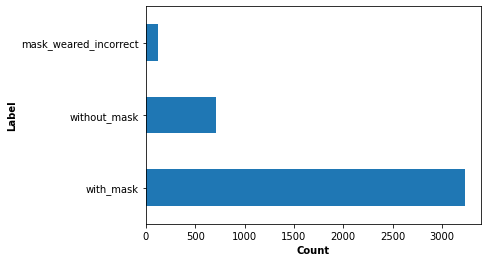

In [11]:
df["label"].value_counts().plot(kind='barh')
plt.xlabel('Count', fontsize = 10, fontweight = 'bold')
plt.ylabel('Label', fontsize = 10, fontweight = 'bold')

Chuẩn bị dữ liệu

In [12]:
labels = df['label'].unique()
directory = ['train', 'test', 'val']
output_data_path =  '.'

import os
for label in labels:
    for d in directory:
        path = os.path.join(output_data_path, d, label)
        #print(path)
        if not os.path.exists(path):
            os.makedirs(path)

In [13]:
from PIL import Image
def crop_img(image_path, x_min, y_min, x_max, y_max):
    
    '''
     This function takes an image path + x and y coordinates of two opposite corners of the rectangle 
     and returns a cropped image
    '''
    x_shift = (x_max - x_min) * 0.1
    y_shift = (y_max - y_min) * 0.1
    img = Image.open(image_path)
    cropped = img.crop((x_min - x_shift, y_min - y_shift, x_max + x_shift, y_max + y_shift))
    return cropped

In [14]:
def extract_faces(image_name, image_info):
    
    '''
     Hàm này lấy tên hình ảnh + khung dữ liệu với thông tin về hình ảnh
     và chia hình ảnh thành tất cả các khuôn mặt khác nhau. tên hình ảnh có chứa
     tọa độ phía trên bên trái của mỗi khuôn mặt để chúng ta có thể phân biệt nó sau này
    '''
    faces = []
    df_one_img = image_info[image_info['file_name'] == image_name[:-4]][['xmin', 'ymin', 'xmax', 'ymax', 'label']]
    #print(df_one_img)
    for row_num in range(len(df_one_img)):
        x_min, y_min, x_max, y_max, label = df_one_img.iloc[row_num] 
        image_path = os.path.join(input_data_path, image_name)
        faces.append((crop_img(image_path, x_min, y_min, x_max, y_max), label,f'{image_name[:-4]}_{(x_min, y_min)}'))
    return faces

In [15]:
cropped_faces = [extract_faces(img, df) for img in images]

In [16]:
#flat_cropped_faces = [item for sublist in cropped_faces for item in sublist]
flat_cropped_faces = sum(cropped_faces, [])
#flat_cropped_faces

Sắp xếp các hình ảnh vào nhãn của chúng theo 3 lớp.

In [17]:
with_mask = [(img, image_name) for img, label,image_name in flat_cropped_faces if label == "with_mask"]
mask_weared_incorrect = [(img, image_name) for img, label,image_name in flat_cropped_faces if label == "mask_weared_incorrect"]
without_mask = [(img, image_name) for img, label,image_name in flat_cropped_faces if label == "without_mask"]

In [18]:
print(f'so hinh anh co khau trang: {len(with_mask)}')
print(f'so hinh anh khong khau trang: {len(without_mask)}')
print(f'so hinh anh deo khau trang khong hop le: {len(mask_weared_incorrect)}')
print(f'Tong: {len(with_mask) + len(without_mask) + len(mask_weared_incorrect) }')

so hinh anh co khau trang: 3231
so hinh anh khong khau trang: 715
so hinh anh deo khau trang khong hop le: 123
Tong: 4069


Chia tập dữ liệu đầy đủ thành các tập huấn luyện (80%) và kiểm tra (20%). Bộ kiểm tra được chia lại thành bộ kiểm tra (30%) và xác thực (70%)

In [19]:
from sklearn.model_selection import train_test_split

train_with_mask, test_with_mask = train_test_split(with_mask, test_size=0.20, random_state=42)
test_with_mask, val_with_mask = train_test_split(test_with_mask, test_size=0.7, random_state=42)

train_mask_weared_incorrect, test_mask_weared_incorrect = train_test_split(mask_weared_incorrect, test_size=0.20, random_state=42)
test_mask_weared_incorrect, val_mask_weared_incorrect = train_test_split(test_mask_weared_incorrect, test_size=0.7, random_state=42)

train_without_mask, test_without_mask = train_test_split(without_mask, test_size=0.20, random_state=42)
test_without_mask, val_without_mask = train_test_split(test_without_mask, test_size=0.7, random_state=42)

In [20]:
def save_image(image, image_name, output_data_path,  dataset_type, label):
    '''
     
Hàm này lấy tên hình ảnh + đường dẫn của thư mục đầu ra
     và lưu hình ảnh vào thư mục đầu ra
    '''

    output_path = os.path.join(output_data_path, dataset_type, label ,f'{image_name}.png')
    image.save(output_path)   

In [21]:
# Train set


for image, image_name in train_with_mask:
    save_image(image, image_name, output_data_path, 'train', 'with_mask')

for image, image_name in train_mask_weared_incorrect:
    save_image(image, image_name, output_data_path, 'train', 'mask_weared_incorrect')

for image, image_name in train_without_mask:
    save_image(image, image_name, output_data_path, 'train', 'without_mask')
        
# Test set

for image, image_name in test_with_mask:
    save_image(image, image_name, output_data_path, 'test', 'with_mask')

for image, image_name in test_mask_weared_incorrect:
    save_image(image, image_name, output_data_path, 'test', 'mask_weared_incorrect')

for image, image_name in test_without_mask:
    save_image(image, image_name, output_data_path, 'test', 'without_mask')
    
# Val set
    
for image, image_name in val_with_mask:
    save_image(image, image_name, output_data_path, 'val', 'with_mask')

for image, image_name in val_without_mask:
    save_image(image, image_name, output_data_path, 'val', 'without_mask')

for image, image_name in val_mask_weared_incorrect:
    save_image(image, image_name, output_data_path, 'val', 'mask_weared_incorrect')

Xây dựng model - CNN

In [22]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

model = Sequential()
model.add(Conv2D(filters = 16, kernel_size = 3,  padding='same', activation = 'relu', input_shape = (35,35,3)))
model.add(MaxPooling2D(pool_size = 2))
model.add(Conv2D(filters = 32, kernel_size = 3,  padding='same', activation = 'relu'))
model.add(MaxPooling2D(pool_size = 2))
model.add(Conv2D(filters = 64, kernel_size = 3,  padding='same', activation = 'relu'))
model.add(MaxPooling2D(pool_size = 2))
model.add(Dropout(0.3))
model.add(Flatten())
model.add(Dense(units = 500, activation = 'relu'))
model.add(Dropout(0.3))
model.add(Dense(units = 3, activation = 'softmax'))


model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 35, 35, 16)        448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 17, 17, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 17, 17, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 8, 8, 32)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 8, 8, 64)          18496     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 4, 4, 64)         0

Vẽ sơ đồ kiến trúc mô hìnhPlotting the model architecture

In [23]:
from keras.utils.vis_utils import plot_model

plot_model(model, show_shapes=True, show_layer_names=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [24]:
batch_size = 8
epochs = 50

In [25]:
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    rescale=1.0 / 255, horizontal_flip=True, zoom_range=0.1, shear_range=0.2, width_shift_range=0.1,
    height_shift_range=0.1, rotation_range=4, vertical_flip=False

)

val_datagen = ImageDataGenerator(
    rescale=1.0 / 255
)
 

train_generator = datagen.flow_from_directory(
    directory='C:/mask/train', 
    target_size = (35,35),
    class_mode="categorical", batch_size=batch_size, shuffle=True

)

# Validation data
val_generator = val_datagen.flow_from_directory(
    directory='C:/mask/val', 
    target_size = (35,35),
    class_mode="categorical", batch_size=batch_size, shuffle=True
)

# Test data
test_generator = val_datagen.flow_from_directory(
    directory='C:/mask/test', 
    target_size = (35,35),
    class_mode="categorical", batch_size=batch_size, shuffle=False
)

Found 3254 images belonging to 3 classes.
Found 572 images belonging to 3 classes.
Found 243 images belonging to 3 classes.


In [26]:
data_size = len(train_generator) 
#data_size2 = train_generator.n

#print(f"data_size: {data_size}, {data_size2}")

steps_per_epoch = int(data_size / batch_size)
print(f"steps_per_epoch: {steps_per_epoch}")

val_steps = int(len(val_generator) // batch_size)
#print(f"val size: {len(val_generator)}")
print(f"val_steps: {val_steps}")

steps_per_epoch: 50
val_steps: 9


In [27]:
# Compiling the model
model.compile(
    optimizer="adam",
    loss="categorical_crossentropy",
    #metrics="accuracy"
    metrics=['accuracy', 'Recall', 'Precision', 'AUC']

)
#model.optimizer.lr=0.001

In [28]:
from tensorflow.keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True)

Giảm tỷ lệ học tập trên cao nguyên

In [29]:
from tensorflow.keras.callbacks import ReduceLROnPlateau

lrr = ReduceLROnPlateau(monitor='val_loss',patience=8,verbose=1,factor=0.5, min_lr=0.00001)

In [30]:
# Fit the model on train data

model_history = model.fit_generator(
    generator=train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=epochs,
    shuffle=True,
    #verbose=2,
    validation_data=val_generator,
    validation_steps=val_steps,
    callbacks=[early_stopping, lrr]
)

C:\Users\Asus\AppData\Local\Temp\ipykernel_15736\2332504450.py:3: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model_history = model.fit_generator(


Epoch 1/50
50/50 [==============================] - 7s 111ms/step - loss: 0.5980 - accuracy: 0.8025 - recall: 0.7825 - precision: 0.8067 - auc: 0.9005 - val_loss: 0.3987 - val_accuracy: 0.8333 - val_recall: 0.8333 - val_precision: 0.8333 - val_auc: 0.9729 - lr: 0.0010
Epoch 2/50
50/50 [==============================] - 5s 93ms/step - loss: 0.5100 - accuracy: 0.8100 - recall: 0.8075 - precision: 0.8157 - auc: 0.9307 - val_loss: 0.3918 - val_accuracy: 0.8056 - val_recall: 0.7917 - val_precision: 0.8143 - val_auc: 0.9609 - lr: 0.0010
Epoch 3/50
50/50 [==============================] - 4s 70ms/step - loss: 0.3139 - accuracy: 0.8975 - recall: 0.8775 - precision: 0.9023 - auc: 0.9742 - val_loss: 0.1223 - val_accuracy: 0.9722 - val_recall: 0.9583 - val_precision: 0.9718 - val_auc: 0.9959 - lr: 0.0010
Epoch 4/50
50/50 [==============================] - 4s 83ms/step - loss: 0.2887 - accuracy: 0.8950 - recall: 0.8925 - precision: 0.9130 - auc: 0.9778 - val_loss: 0.2397 - val_accuracy: 0.9444 - v

In [31]:
# Đánh giá hiệu suất mô hình trên dữ liệu thử nghiệm
model_loss, model_acc, recall, precision, auc = model.evaluate(test_generator)
print("Model has a loss of %.2f and accuracy %.2f%%" % (model_loss, model_acc*100))
print("Model has a recall of %.2f%%, precision of %.2f%% and auc of %.2f%%" % (recall*100, precision*100, auc*100))

31/31 [==============================] - 3s 87ms/step - loss: 0.1813 - accuracy: 0.9342 - recall: 0.9342 - precision: 0.9342 - auc: 0.9911
Model has a loss of 0.18 and accuracy 93.42%
Model has a recall of 93.42%, precision of 93.42% and auc of 99.11%


In [32]:
predictions = model.predict(test_generator)
print("predictions shape:", predictions.shape)

31/31 [==============================] - 1s 19ms/step
predictions shape: (243, 3)


In [33]:
def plot_loss_and_accuracy(history):
    history_df = pd.DataFrame(history)
    fig, ax = plt.subplots(1,2, figsize=(12, 6))
    
    history_df.loc[0:, ['loss', 'val_loss']].plot(ax=ax[0])
    ax[0].set(xlabel = 'epoch number', ylabel = 'loss')

    history_df.loc[0:, ['accuracy', 'val_accuracy']].plot(ax=ax[1])
    ax[1].set(xlabel = 'epoch number', ylabel = 'accuracy')

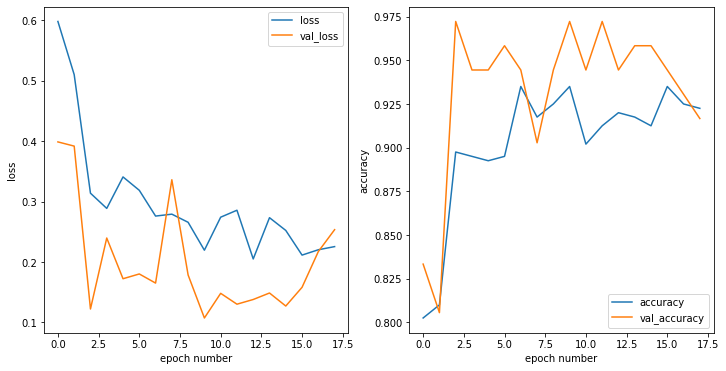

In [34]:
plot_loss_and_accuracy(model_history.history)

Chọn ngẫu nhiên một hình ảnh từ bộ thử nghiệm và kiểm tra sự khác biệt giữa ghi nhãn ban đầu và dự đoán mô hình

31/31 [==============================] - 1s 18ms/step
Class Predicted: with_mask , True label: with_mask\maksssksksss724_(303, 24).png


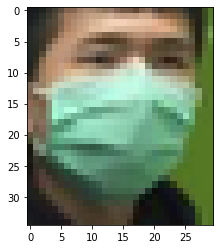

In [35]:
import cv2

paths = test_generator.filenames # Your files path

y_pred = model.predict(test_generator).argmax(axis=1) # Predict prob and get Class Indices
classes = test_generator.class_indices  # Map of Indices to Class name

a_img_rand = np.random.randint(0,len(paths))   # A rand to pick a rand image
img = cv2.imread(os.path.join(output_data_path,'test', paths[a_img_rand]))      
colored_img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)  # colored output image

#img = image.img_to_array(img)
plt.imshow(colored_img)
true_label = paths[a_img_rand].split('/')[0]
predicted_label = list(classes)[y_pred[a_img_rand]]
print(f'Class Predicted: {predicted_label} , True label: {true_label}')

In [36]:
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import precision_score, recall_score, accuracy_score,f1_score, classification_report

import seaborn as sns 

def evaluation(y, y_hat, title = 'Confusion Matrix'):
    """Evaluation function
    Prints Classification reports and confusion matrix
    """
    cm = confusion_matrix(y, y_hat)
#     precision = precision_score(y, y_hat)
#     recall = recall_score(y, y_hat)
#     accuracy = accuracy_score(y,y_hat)
#     f1 = f1_score(y,y_hat)
#     report = classification_report(y,y_hat)
#     print(report)
#     print('Recall: ', recall)
#     print('Accuracy: ', accuracy)
#     print('Precision: ', precision)
#     print('F1: ', f1)
    sns.heatmap(cm,  cmap= 'PuBu', annot=True, fmt='g', annot_kws={'size':20})
    plt.xlabel('predicted', fontsize=18)
    plt.ylabel('actual', fontsize=18)
    plt.title(title, fontsize=18)
    
    plt.show()

31/31 [==============================] - 1s 21ms/step


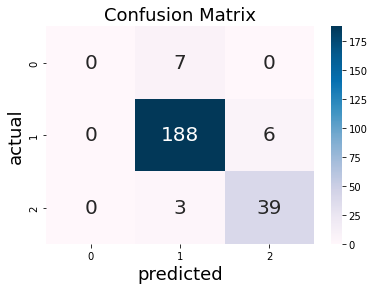

In [37]:
y_true = test_generator.labels
y_pred = model.predict(test_generator).argmax(axis=1) # Predict prob and get Class Indices

evaluation(y_true, y_pred)

In [38]:
classes

{'mask_weared_incorrect': 0, 'with_mask': 1, 'without_mask': 2}

In [39]:
np.bincount(y_pred) # Use bincount() to count occurrences of each class in a predictions NumPy array

array([  0, 198,  45], dtype=int64)

Kiểm tra kết quả

1/1 [==============================] - 0s 62ms/step


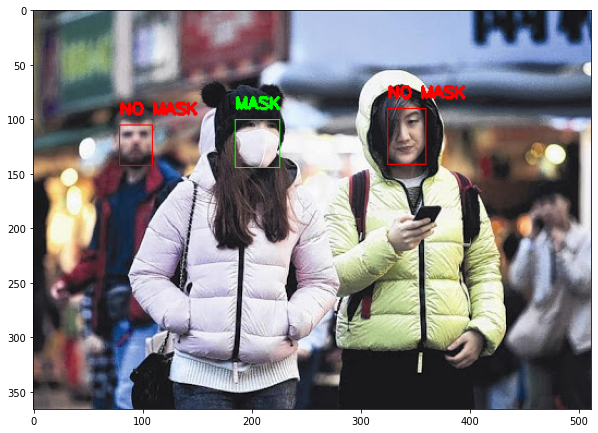

In [40]:
import cv2
img = cv2.imread(os.path.join(input_data_path, f'{final_test_image}.png'))      
colored_img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)  # colored output image

#print(type(colored_img))
mask_label = {0:'MASK INCORRECT',1:'MASK', 2:'NO MASK'}
color_label = {0:(0,255,255),1:(0, 255,0), 2:(255,0,0)}
cropped_faces = extract_faces(f'{final_test_image}.png', df_final_test)

df_test_img = df_final_test[['xmin', 'ymin', 'xmax', 'ymax', 'label']]
#df_test_img
#for row_num in range(len(df_test_img)):
for idx, face in enumerate(cropped_faces):    
    #print(idx)
    x_min, y_min, x_max, y_max, label = df_test_img.iloc[idx] 
    #print(x_min, y_min, x_max, y_max, label)
    #print(face[0])
    resized_face = cv2.resize(np.array(face[0]),(35,35))
    reshaped_face = np.reshape(resized_face,[1,35,35,3])/255.0

    face_result = model.predict(reshaped_face)
    cv2.putText(colored_img,mask_label[face_result.argmax()],(x_min, y_min-10),cv2.FONT_HERSHEY_SIMPLEX,0.5,color_label[face_result.argmax()],2)
    cv2.rectangle(colored_img,(x_min, y_min), (x_max, y_max), color_label[face_result.argmax()]) # print a blue rectangle of each person's face using the given coordinates

plt.figure(figsize=(10, 10))    
plt.imshow(colored_img)